In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from skimage import filters
%matplotlib inline

In [ ]:
img = plt.imread('Image.png')

Pertama-tama kita melakukan noise filtering dulu dengan gaussian filter, tujuannya untuk menghilangkan noise

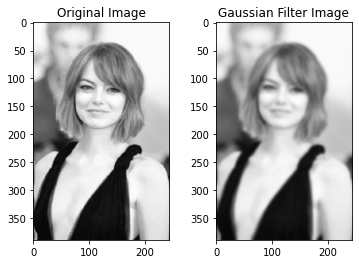

In [ ]:
kernel = cv.getGaussianKernel(31, 2)

kernel = kernel.dot(kernel.T)

img_gaussian = cv.filter2D(img, -1, kernel)

plt.figure(1)
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(122)
plt.imshow(img_gaussian)
plt.title("Gaussian Filter Image")
plt.show()

Kemudian kita mencari gradient, tujuan dari mencari gradient ini adalah untuk mendapatkan edge dari gambarnya. Kita melakukan pencarian turunan secara 2 kali yaitu untuk X dan untuk Y

In [ ]:
def gaussian_kernel_x(size, sigma):
    if size % 2 == 0:
        size = size + 1

    max_point = size // 2  # mencari maximum start point
    min_point = -max_point  # negatif dari max point kita gunakan untuk minimum point

    K_x = np.zeros((size, size))
    for x in range(min_point, max_point + 1):
        for y in range(min_point, max_point + 1):
            value = (-x / (2 * np.pi * (sigma ** 4)) * np.exp((-(x ** 2 + y ** 2)) / (2 * (sigma ** 2))))
            K_x[x - min_point, y - min_point] = value

    return K_x


def gaussian_kernel_y(size, sigma):
    if size % 2 == 0:
        size = size + 1

    max_point = size // 2  # mencari maximum start point
    min_point = -max_point  # negatif dari max point kita gunakan untuk minimum point

    K_y = np.zeros((size, size))
    for x in range(min_point, max_point + 1):
        for y in range(min_point, max_point + 1):
            value = (-y / (2 * np.pi * (sigma ** 4)) * np.exp((-(x ** 2 + y ** 2)) / (2 * (sigma ** 2))))
            K_y[x - min_point, y - min_point] = value

    return K_y

In [ ]:
imgx = cv.imread("Image.png", cv.IMREAD_GRAYSCALE)

Hasil dari turunan X dan Y dari gambar tersebut

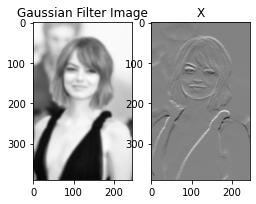

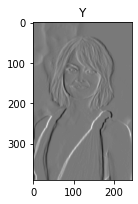

In [ ]:
imgx = np.float64(imgx)
img_gaussian = np.float64(img_gaussian)

mask_x = np.zeros((2, 1))
mask_x[0] = -1
mask_x[1] = 1

I_x = cv.filter2D(imgx, -1, gaussian_kernel_x(5, 1))
mask_y = mask_x.T
I_y = cv.filter2D(imgx, -1, gaussian_kernel_y(5, 1))

plt.figure(1)
plt.subplot(131)
plt.imshow(img_gaussian, cmap="gray")
plt.title("Gaussian Filter Image")

plt.subplot(132)
plt.imshow(I_x, cmap="gray")
plt.title("X")
plt.show()

plt.subplot(133)
plt.imshow(I_y, cmap="gray")
plt.title("Y")
plt.show()

Turunan dari X dan Y ini kita gunakan untuk mencari Gradient Magnitude dan Gradient Direction

In [ ]:
Gm = (I_x ** 2 + I_y ** 2) ** 0.5
Gd = np.rad2deg(np.arctan2(I_y, I_x))

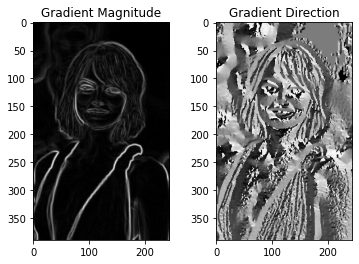

In [ ]:
plt.figure(1)

plt.subplot(121)
plt.imshow(Gm, cmap="gray")
plt.title("Gradient Magnitude")

plt.subplot(122)
plt.imshow(Gd, cmap="gray")
plt.title("Gradient Direction")

plt.show()

Lalu Non Maximum Suppression kita gunakan agar edgenya menjadi tidak saling overlapping sehingga meningkatkan sharpness dari edge detection yang kita gunakan.

In [ ]:
def f_NMS(Gm, Gd):
    num_rows, num_cols = Gm.shape[0], Gm.shape[1]
    Gd_bins = 45 * (np.round(Gd / 45))

    G_NMS = np.zeros(Gm.shape)

    neighbor_a, neighbor_b = 0., 0.

    for r in range(1, num_rows - 1):
        for c in range(1, num_cols - 1):
            angle = Gd_bins[r, c]
            if angle == 180. or angle == -180. or angle == 0.:
                neighbor_a, neighbor_b = Gm[r + 1, c], Gm[r - 1, c]
            elif angle == 90. or angle == -90.:
                neighbor_a, neighbor_b = Gm[r, c - 1], Gm[r, c + 1]
            elif angle == 45. or angle == -135.:
                neighbor_a, neighbor_b = Gm[r + 1, c + 1], Gm[r - 1, c - 1]
            elif angle == -45. or angle == 135.:
                neighbor_a, neighbor_b = Gm[r - 1, c + 1], Gm[r + 1, c - 1]
            else:
                print("error")
                return

            if Gm[r, c] > neighbor_a and Gm[r, c] > neighbor_b:
                G_NMS[r, c] = Gm[r, c]

    return G_NMS

In [ ]:
bins = np.array([-180., -135., -90., -45., 0., 45., 90., 135., 180.])

inds = np.digitize(Gd, bins) - 1
Gd_bin = bins[inds.flatten()].reshape(Gd.shape)

print(Gd.max(), Gd.min())
G_NMS = f_NMS(Gm, Gd)

L = G_NMS.mean()
H = L + G_NMS.std()
E = filters.apply_hysteresis_threshold(G_NMS, L, H)



180.0 -180.0


Dan terakhir kita menggunakan hysteresis, tujuan dari hysteresis ini untuk menyambungkan garis-garis yang putus karena edge yang terlalu lemah dapat disambungkan dengan edge yang lebih kuat. Hasil sambungan ini akan menunjukkan edge sesungguhnya dari image yang telah diberikan

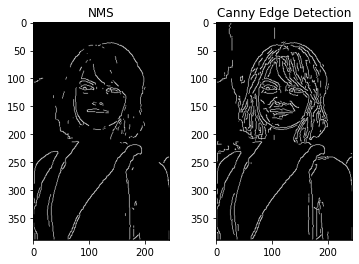

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.imshow(G_NMS>15, cmap="gray")
plt.title("NMS")

plt.subplot(122)
plt.imshow(E, cmap="gray")
plt.title("Canny Edge Detection")

plt.show()